In [1]:
# For each iteration of outputs, plot the objective functions for each basins and save to a PDF file

In [1]:
import numpy as np
import os, glob, sys, toml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize
import matplotlib.cm as cm


In [33]:
# basin range (start from 1)
bstart = 1
bend = 627

# iteration range (start from 0)
istart = 0
iend = 7

path0 = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO'

maxiter = 16 # used for plotting

In [34]:
# basin info
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
ds_info = pd.read_csv(file)
# ds_info.head()

In [35]:
# Create a PDF file to save the plots

# Create a colormap
# cmap = cm.tab20 
cmap = cm.cool
norm = Normalize(vmin=0, vmax=maxiter-1)  # Set the normalization from 0 to 15

values = np.linspace(0, maxiter-1, maxiter)
colors = cmap(norm(values))

minobjfuncs_all = []

file_plot = f'camels_b{bstart}-{bend}_i{istart}-{iend}.pdf'
with PdfPages(file_plot) as pdf:

    for b in range(bstart-1, bend):
        fig = plt.figure(figsize=[8, 6])

        # load basin metrics
        df_met = pd.DataFrame()
        minobjfuncs = []
        emulator_metric = []
        for i in range(istart, iend+1):
            filemet = f'{path0}/level1_{b}_MOASMOcalib/ctsm_outputs/iter{i}_all_metric.csv'
            dfi = pd.read_csv(filemet)
            dfi['iter'] = i
            minobjfuncs.append( np.min(dfi['metric1'].values + dfi['metric2'].values) )
            df_met = pd.concat([df_met, dfi])

            # load emulator metric
            filemet1 = f'{path0}/level1_{b}_MOASMOcalib/param_sets/GPR_for_iter{i}_CV_kge.csv'
            filemet2 = f'{path0}/level1_{b}_MOASMOcalib/param_sets/RF_for_iter{i}_CV_kge.csv'
            df1 = pd.read_csv(filemet1)
            df2 = pd.read_csv(filemet2)
            
            emulator_metric.append(max(df1['kge_mean'].values[-1], df2['kge_mean'].values[-1]))
    
        met1 = df_met['metric1'].values
        met2 = df_met['metric2'].values
        iters = df_met['iter'].values

        # 1. plot all trials
        fig.add_subplot(2,2,1)
        
        plt.scatter(met1, met2, 5, iters, cmap=cmap, norm=norm)
        plt.colorbar(label='iteration')
        plt.xlabel('daily mean abs error')
        plt.ylabel('max monthly abs error')
        plt.title('(a) All interations')

        # plot the default parameter
        if istart == 0:
            plt.scatter(met1[0], met2[0], 5, color='r')

         # 2. plot all trials (two different colors for the current and previous iterations)
        fig.add_subplot(2,2,2)

        ind = iters==iters[-1]
        plt.scatter(met1[~ind], met2[~ind], 5, color='grey')
        plt.scatter(met1[ind], met2[ind], 5, color='blue')
        plt.xlabel('daily mean abs error')
        plt.ylabel('max monthly abs error')
        plt.title('(b) Current iter. VS Previous iter.')

        # plot the default parameter
        if istart == 0:
            plt.scatter(met1[0], met2[0], 10, color='r')
       

        # 3. plot the performance change (best performance for each iteration)
        fig.add_subplot(2,2,3)
        
        if istart == 0:
            minobjfuncs.insert(0, met1[0] + met2[0])
            minobjfuncs = np.array(minobjfuncs)
            iternames = list(np.arange(istart, iend+1))
            iternames.insert(0, 'defa')
        else:
            minobjfuncs = np.array(minobjfuncs)
            iternames = list(np.arange(istart, iend+1))

        minobjfuncs_all.append(minobjfuncs)
        
        plt.plot(np.arange(len(minobjfuncs)), minobjfuncs, 'o-', color='blue')
        plt.xticks(np.arange(len(minobjfuncs)),  iternames)
            
        plt.xlabel('iteration')
        plt.ylabel('min of metric 1 + metric 2')
        plt.title('(c) Best performance for each iteration')

        # 4. insert text
        fig.add_subplot(2,2,4)
        plt.axis('off')
        s = ds_info.iloc[b]['hru_id']
        plt.text(0.1, 0.8, f'hru_id: {s}')
        s = ds_info.iloc[b]['lat_cen']
        plt.text(0.1, 0.7, f'lat_cen: {s}')
        s = ds_info.iloc[b]['lon_cen']
        plt.text(0.1, 0.6, f'lon_cen: {s}')
        s = ds_info.iloc[b]['AREA']/1e6
        plt.text(0.1, 0.5, f'AREA: {s:.2f} km2')
        s = ds_info.iloc[b]['elev_mean']
        plt.text(0.1, 0.4, f'elev_mean: {s:.2f} m')

        plt.text(0.1, 0.3, f'iter{iend} emulator CV: {emulator_metric[-1]:.2f}')

        plt.tight_layout()
        pdf.savefig(fig)  # Save the current figure into the PDF
        plt.close(fig)  # Close the figure to free memory


# plot improvements of current iteration compared to the previous iteration

In [8]:
# basin range (start from 1)
bstart = 1
bend = 627

# iteration range (start from 0)
istart = 0
iend = 7

path0 = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO'


minobjfuncs_all = []
emulator_metric_all = []
for b in range(bstart - 1, bend):
    # load basin metrics
    df_met = pd.DataFrame()
    minobjfuncs = []
    emulator_metric = []
    for i in range(istart, iend + 1):
        # evaluation metric
        filemet = f'{path0}/level1_{b}_MOASMOcalib/ctsm_outputs/iter{i}_all_metric.csv'
        dfi = pd.read_csv(filemet)
        dfi['iter'] = i
        minobjfuncs.append(np.min(dfi['metric1'].values + dfi['metric2'].values))

        df_met = pd.concat([df_met, dfi])

        # load emulator metric
        filemet1 = f'{path0}/level1_{b}_MOASMOcalib/param_sets/GPR_for_iter{i}_CV_kge.csv'
        filemet2 = f'{path0}/level1_{b}_MOASMOcalib/param_sets/RF_for_iter{i}_CV_kge.csv'
        df1 = pd.read_csv(filemet1)
        df2 = pd.read_csv(filemet2)
        
        emulator_metric.append(max(df1['kge_mean'].values[-1], df2['kge_mean'].values[-1]))

    met1 = df_met['metric1'].values
    met2 = df_met['metric2'].values

    if istart == 0:
        minobjfuncs.insert(0, met1[0] + met2[0])
        minobjfuncs = np.array(minobjfuncs)
        iternames = list(np.arange(istart, iend + 1))
        iternames.insert(0, 'defa')
    else:
        minobjfuncs = np.array(minobjfuncs)
        iternames = list(np.arange(istart, iend + 1))

    minobjfuncs_all.append(minobjfuncs)
    emulator_metric_all.append(emulator_metric)

minobjfuncs_all = np.array(minobjfuncs_all)
emulator_metric_all = np.array(emulator_metric_all)

improvement = (minobjfuncs_all[:, -1] - minobjfuncs_all[:, -2]) / minobjfuncs_all[:, -2]

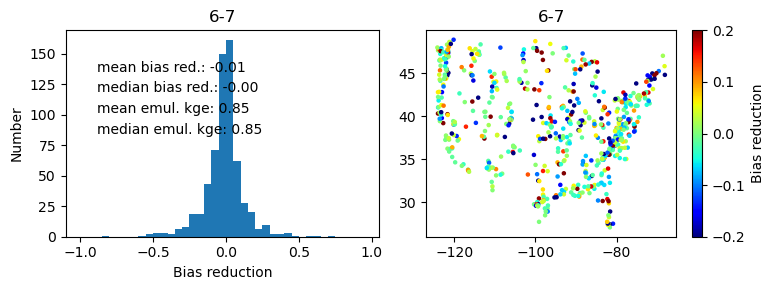

In [21]:
title = f'{iternames[-2]}-{iternames[-1]}'

fig = plt.figure(figsize=[8, 3])

ax = fig.add_subplot(1, 2, 1)
plt.hist(improvement, np.arange(-1, 1, 0.05))
plt.xlabel('Bias reduction')
plt.ylabel('Number')
plt.title(title)

m1 = np.nanmean(improvement)
m2 = np.nanmedian(improvement)
m3 = np.nanmean(emulator_metric_all[:,-1]) # mean emulator performance
m4 = np.nanmedian(emulator_metric_all[:,-1]) # median emulator performance


ax.text(0.1, 0.8, f'mean bias red.: {m1:.2f}', transform=ax.transAxes)
ax.text(0.1, 0.7, f'median bias red.: {m2:.2f}', transform=ax.transAxes)
ax.text(0.1, 0.6, f'mean emul. kge: {m3:.2f}', transform=ax.transAxes)
ax.text(0.1, 0.5, f'median emul. kge: {m4:.2f}', transform=ax.transAxes)


fig.add_subplot(1, 2, 2)
plt.scatter(ds_info['lon_cen'], ds_info['lat_cen'], 5, improvement, cmap='jet', vmin=-0.2, vmax=0.2)
plt.colorbar(label='Bias reduction')
plt.title(title)

plt.tight_layout()
# plt.show()
plt.savefig(f'iteration_gain_{title}.pdf')

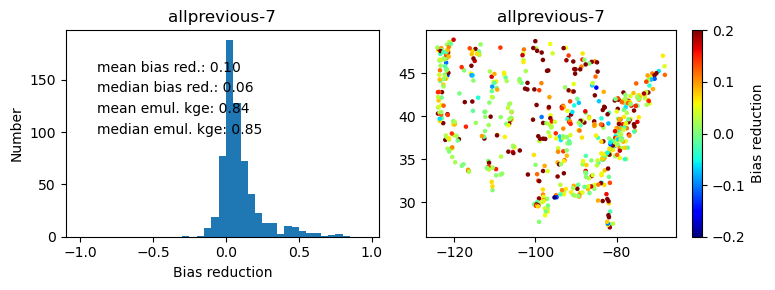

In [28]:
title = f'allprevious-{iternames[-1]}'

prev_minobj = np.nanmin(minobjfuncs_all[:, :-1],axis=1)
improvement_overall = (minobjfuncs_all[:, -1] - prev_minobj) / prev_minobj


fig = plt.figure(figsize=[8, 3])

ax = fig.add_subplot(1, 2, 1)
plt.hist(improvement_overall, np.arange(-1, 1, 0.05))
plt.xlabel('Bias reduction')
plt.ylabel('Number')
plt.title(title)

m1 = np.nanmean(improvement_overall)
m2 = np.nanmedian(improvement_overall)
m3 = np.nanmean(emulator_metric_all[:,-1]) # mean emulator performance
m4 = np.nanmedian(emulator_metric_all[:,-1]) # median emulator performance

ax.text(0.1, 0.8, f'mean bias red.: {m1:.2f}', transform=ax.transAxes)
ax.text(0.1, 0.7, f'median bias red.: {m2:.2f}', transform=ax.transAxes)
ax.text(0.1, 0.6, f'mean emul. kge: {m3:.2f}', transform=ax.transAxes)
ax.text(0.1, 0.5, f'median emul. kge: {m4:.2f}', transform=ax.transAxes)


fig.add_subplot(1, 2, 2)
plt.scatter(ds_info['lon_cen'], ds_info['lat_cen'], 5, improvement_overall, cmap='jet', vmin=-0.2, vmax=0.2)
plt.colorbar(label='Bias reduction')
plt.title(title)

plt.tight_layout()
# plt.show()
plt.savefig(f'iteration_gain_{title}.pdf')

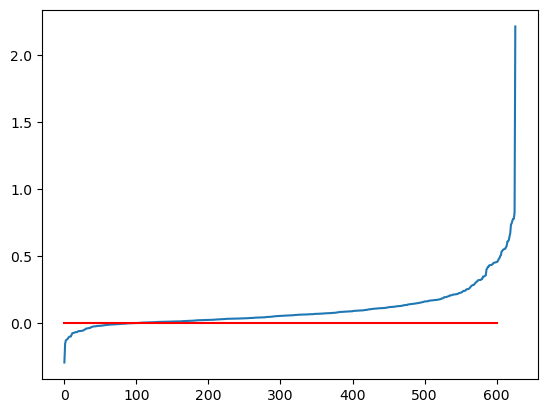

In [32]:
plt.plot(np.sort(improvement_overall))
plt.plot([0, 600],[0,0],'r')

In [1]:
import xarray as xr

In [2]:
ds=xr.open_dataset('/glade/campaign/cgd/tss/common/lm_forcing/era5land_merged/era5land_merged_for_SUMMA_195001.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 581, latitude: 281, time: 743)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.9 -124.8 ... -67.2 -67.1 -67.0
  * latitude   (latitude) float32 53.0 52.9 52.8 52.7 ... 25.3 25.2 25.1 25.0
  * time       (time) datetime64[ns] 1950-01-01T01:00:00 ... 1950-01-31T23:00:00
Data variables:
    pptrate    (time, latitude, longitude) float64 ...
    airtemp    (time, latitude, longitude) float32 ...
    airpres    (time, latitude, longitude) float32 ...
    spechum    (time, latitude, longitude) float64 ...
    windspd    (time, latitude, longitude) float32 ...
    SWRadAtm   (time, latitude, longitude) float64 ...
    LWRadAtm   (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-27 03:19:25 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [3]:
xr.open_dataset('/glade/campaign/cgd/tss/common/lm_forcing/era5land/hourly/unzip/total_precipitation/total_precipitation.195001.nc')

<xarray.Dataset>
Dimensions:    (longitude: 581, latitude: 281, time: 743)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.9 -124.8 ... -67.2 -67.1 -67.0
  * latitude   (latitude) float32 53.0 52.9 52.8 52.7 ... 25.3 25.2 25.1 25.0
  * time       (time) datetime64[ns] 1950-01-01T01:00:00 ... 1950-01-31T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-27 03:19:25 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...